<a href="https://colab.research.google.com/github/joseverajim/Actividad4.1/blob/main/Actividad4.1/Actividad4_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# --- Actividad 3.1: Tratamiento de valores nulos ---

# 1) Importar librería
import pandas as pd

# 2) Cargar archivo CSV
# Asegúrate de subir "Ventas_totales.csv" a tu Colab antes de correr este bloque
df = pd.read_csv("Ventas_totales.csv")

# 3) Revisar estructura de la base
print("Columnas del dataset:\n", df.columns)
print("\nTamaño del dataset (filas, columnas):", df.shape)

# 4) Revisar cantidad de nulos por columna
print("\nNulos por columna (antes de imputar):")
print(df.isnull().sum())

# 5) Crear copia del DataFrame para imputar sin modificar el original
df_imp = df.copy()

# 6) Imputación de valores nulos
# Estrategias utilizadas:
# - Si la columna es NUMÉRICA -> reemplazamos nulos con la MEDIA
# - Si la columna es TEXTO/CATEGÓRICA -> reemplazamos nulos con la MODA (valor más frecuente)
for c in df.columns:
    if pd.api.types.is_numeric_dtype(df[c]):
        # Calcular media y rellenar los nulos
        media = df[c].mean()
        df_imp[c] = df[c].fillna(media)
        print(f"Columna '{c}': numérica -> imputada con media = {media:.2f}")
    else:
        # Calcular moda y rellenar los nulos
        moda = df[c].mode(dropna=True)
        if len(moda) > 0:
            df_imp[c] = df[c].fillna(moda[0])
            print(f"Columna '{c}': categórica -> imputada con moda = {moda[0]}")
        else:
            # Si no hay moda, rellenamos con "Sin dato"
            df_imp[c] = df[c].fillna("Sin dato")
            print(f"Columna '{c}': categórica -> imputada con 'Sin dato'")

# 7) Verificar nuevamente los nulos después de imputar
print("\nNulos por columna (después de imputar):")
print(df_imp.isnull().sum())
# Guardamos la base imputada (sin outliers todavía)
df_imp.to_csv("Ventas_totales_imputado.csv", index=False)



Columnas del dataset:
 Index(['indice_tiempo', 'ventas_precios_corrientes',
       'ventas_precios_constantes', 'ventas_totales_canal_venta',
       'salon_ventas', 'canales_on_line', 'ventas_totales_medio_pago',
       'efectivo', 'tarjetas_debito', 'tarjetas_credito', 'otros_medios',
       'ventas_totales_grupo_articulos', 'subtotal_ventas_alimentos_bebidas',
       'bebidas', 'almacen', 'panaderia', 'lacteos', 'carnes',
       'verduleria_fruteria', 'alimentos_preparados_rotiseria',
       'articulos_limpieza_perfumeria', 'indumentaria_calzado_textiles_hogar',
       'electronicos_articulos_hogar', 'otros'],
      dtype='object')

Tamaño del dataset (filas, columnas): (65, 24)

Nulos por columna (antes de imputar):
indice_tiempo                           0
ventas_precios_corrientes               0
ventas_precios_constantes               0
ventas_totales_canal_venta              0
salon_ventas                            6
canales_on_line                         0
ventas_totales_medi

In [5]:
# --- Actividad 4.1: Valores atípicos (continuación) ---
# Punto de partida: df_imp ya existe y fue guardado como "Ventas_totales_imputado.csv"

import numpy as np
import matplotlib.pyplot as plt

# 1) Seleccionar solo columnas numéricas para evaluar outliers
num_cols = df_imp.select_dtypes(include=[np.number]).columns.tolist()
print("\nColumnas numéricas a evaluar:", num_cols)

# ===== Método A: Desviación Estándar (±3σ) =====
# Creamos una máscara que conserva filas DENTRO del rango para TODAS las columnas numéricas
mask_std = np.ones(len(df_imp), dtype=bool)

for c in num_cols:
    mean_c = df_imp[c].mean()
    std_c  = df_imp[c].std(ddof=1)  # ddof=1: desviación estándar muestral
    if std_c == 0 or np.isnan(std_c):  # si no hay variación, no filtramos por esa columna
        continue
    dentro = (df_imp[c] >= mean_c - 3*std_c) & (df_imp[c] <= mean_c + 3*std_c)
    mask_std &= (dentro | df_imp[c].isna())

df_std = df_imp[mask_std].copy()
print(f"\nSTD (±3σ) -> Filas originales: {len(df_imp)} | Filas conservadas: {len(df_std)} | Filas removidas: {len(df_imp) - len(df_std)}")



Columnas numéricas a evaluar: ['ventas_precios_corrientes', 'ventas_precios_constantes', 'ventas_totales_canal_venta', 'salon_ventas', 'canales_on_line', 'ventas_totales_medio_pago', 'efectivo', 'tarjetas_debito', 'tarjetas_credito', 'otros_medios', 'ventas_totales_grupo_articulos', 'subtotal_ventas_alimentos_bebidas', 'bebidas', 'almacen', 'panaderia', 'lacteos', 'carnes', 'verduleria_fruteria', 'alimentos_preparados_rotiseria', 'articulos_limpieza_perfumeria', 'indumentaria_calzado_textiles_hogar', 'electronicos_articulos_hogar', 'otros']

STD (±3σ) -> Filas originales: 65 | Filas conservadas: 61 | Filas removidas: 4


In [6]:
# Guardar CSV
df_std.to_csv("Ventas_totales_outliers_std.csv", index=False)

In [7]:
# ===== Método B: Rango Intercuartílico (IQR) =====
mask_iqr = np.ones(len(df_imp), dtype=bool)

for c in num_cols:
    Q1 = df_imp[c].quantile(0.25)
    Q3 = df_imp[c].quantile(0.75)
    IQR = Q3 - Q1
    if IQR == 0 or np.isnan(IQR):   # si no hay dispersión, no filtramos por esa columna
        continue
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    dentro = (df_imp[c] >= lower) & (df_imp[c] <= upper)
    mask_iqr &= (dentro | df_imp[c].isna())

df_iqr = df_imp[mask_iqr].copy()
print(f"IQR (1.5·IQR) -> Filas originales: {len(df_imp)} | Filas conservadas: {len(df_iqr)} | Filas removidas: {len(df_imp) - len(df_iqr)}")


IQR (1.5·IQR) -> Filas originales: 65 | Filas conservadas: 55 | Filas removidas: 10


In [8]:
# Guardar CSV
df_iqr.to_csv("Ventas_totales_outliers_iqr.csv", index=False)

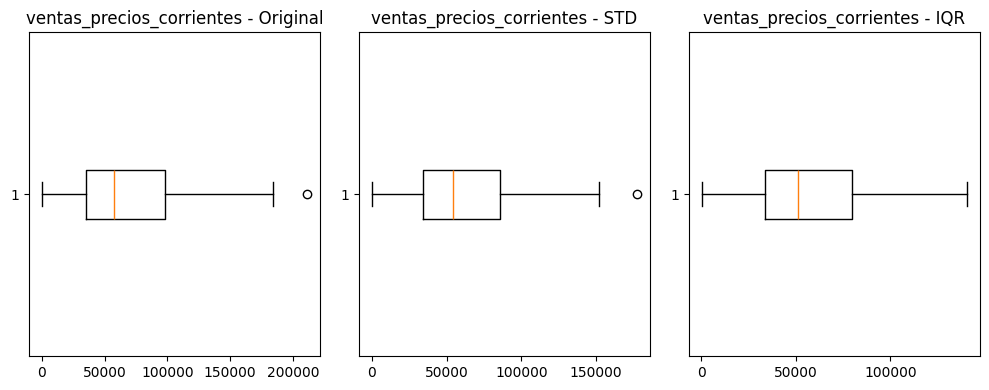

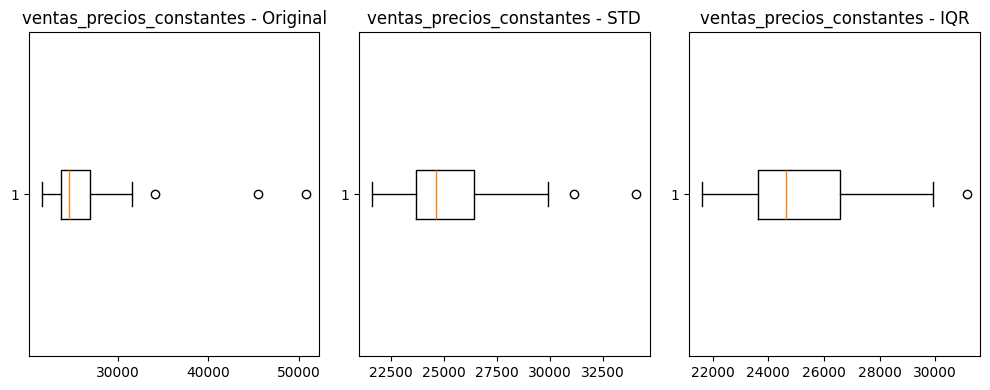

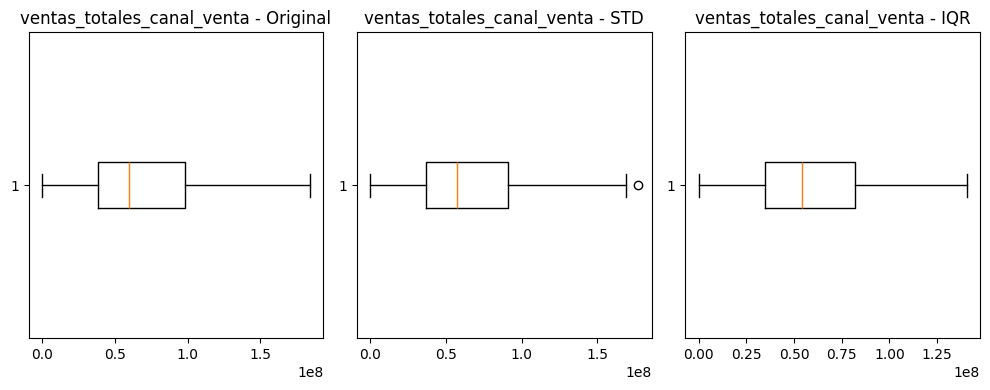

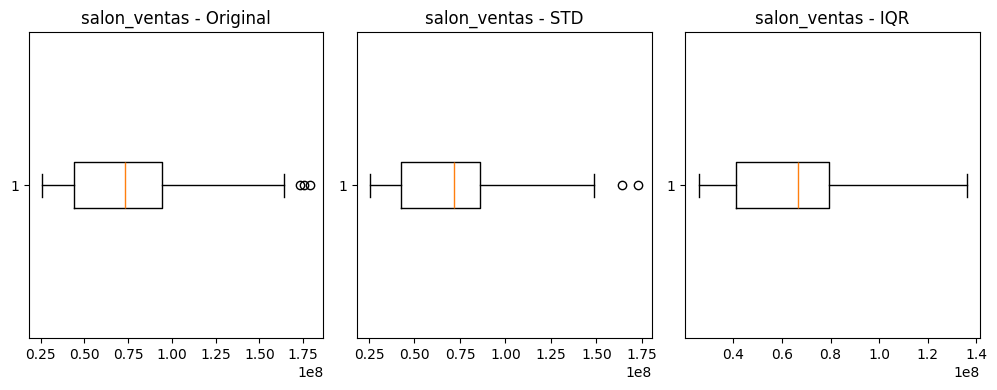

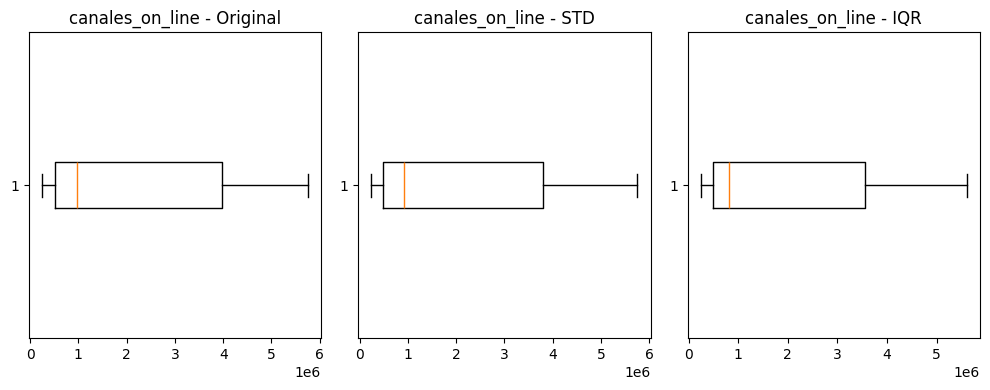

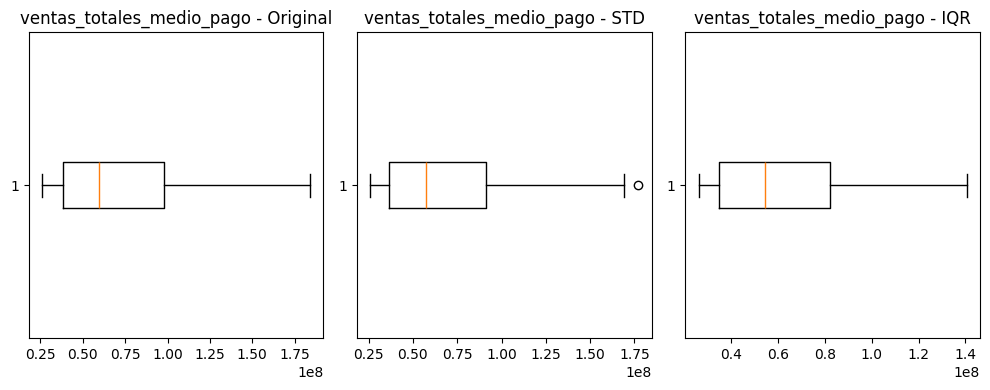

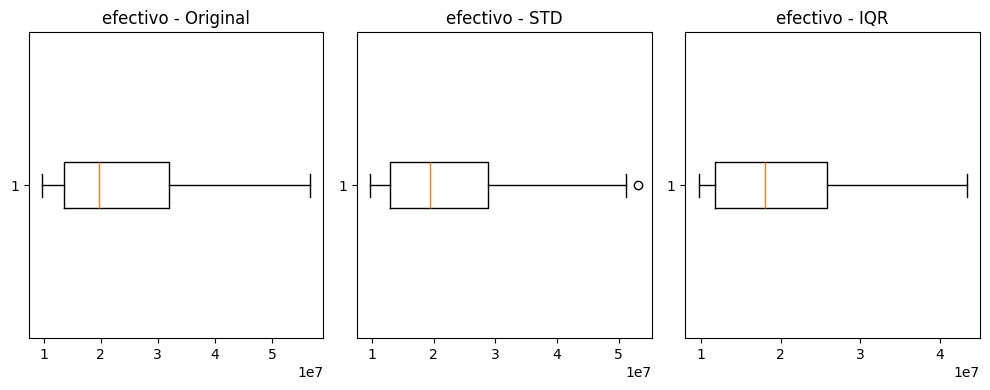

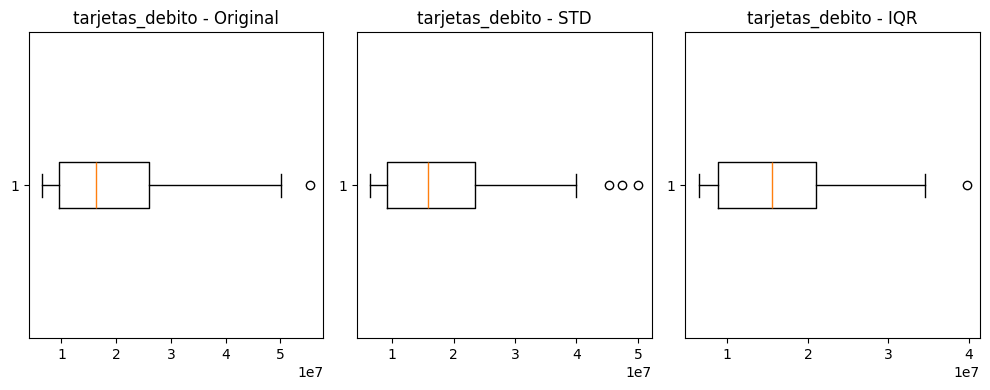

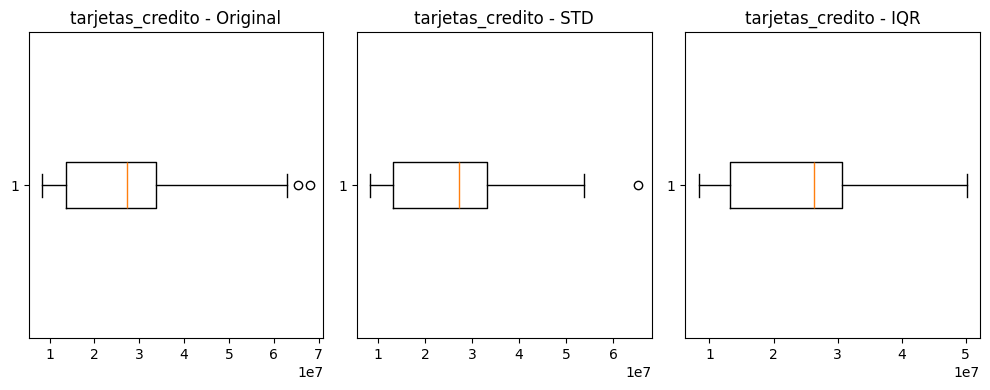

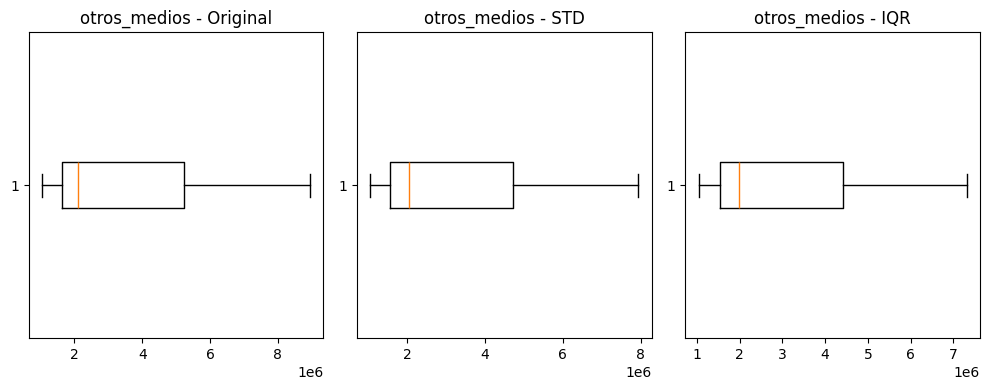

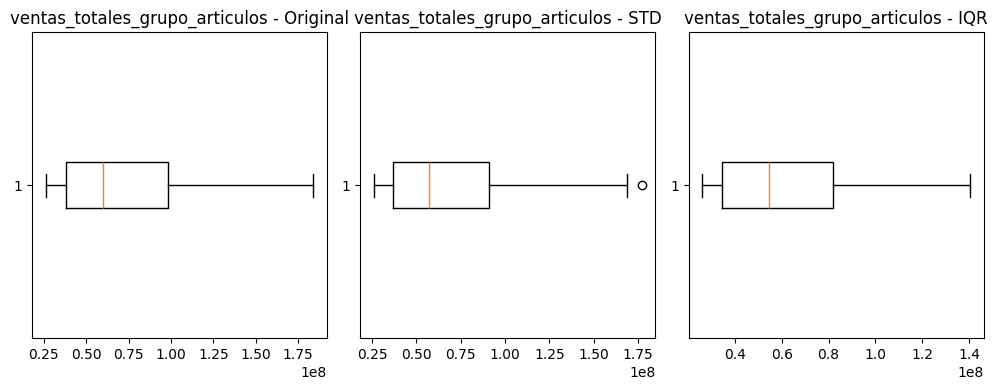

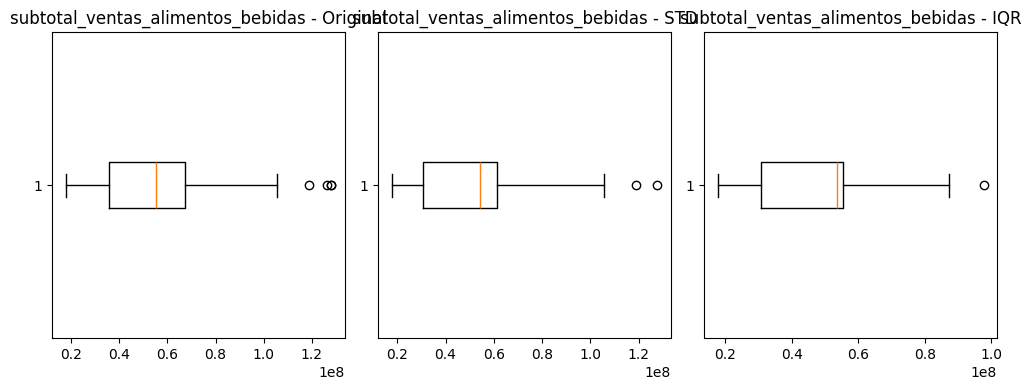

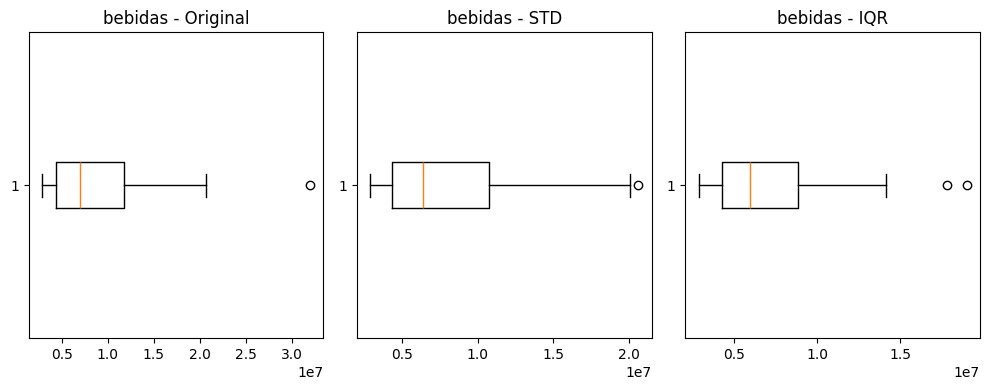

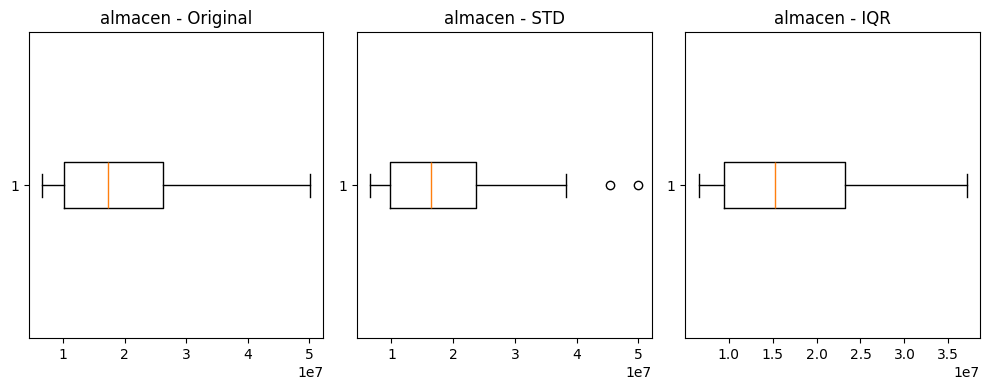

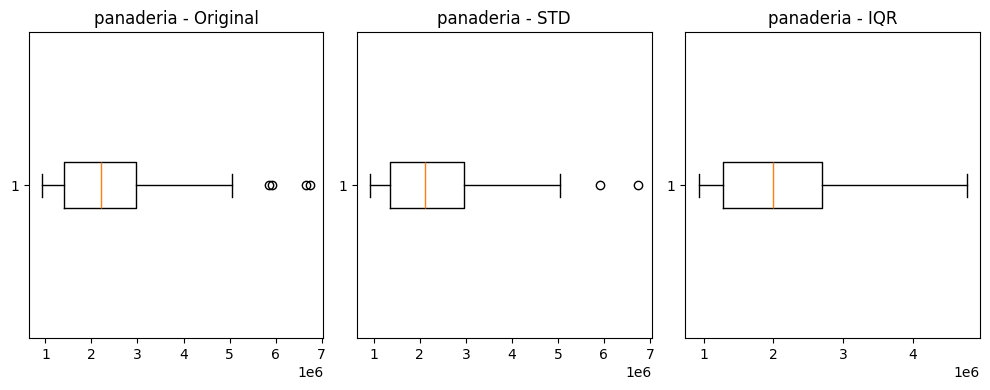

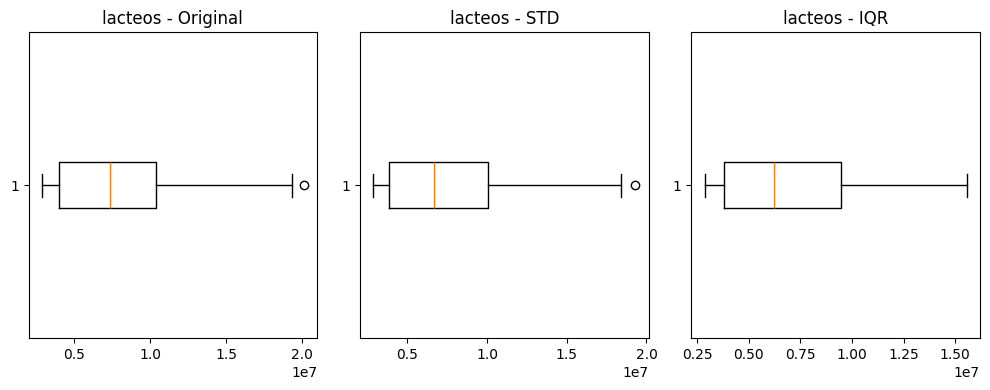

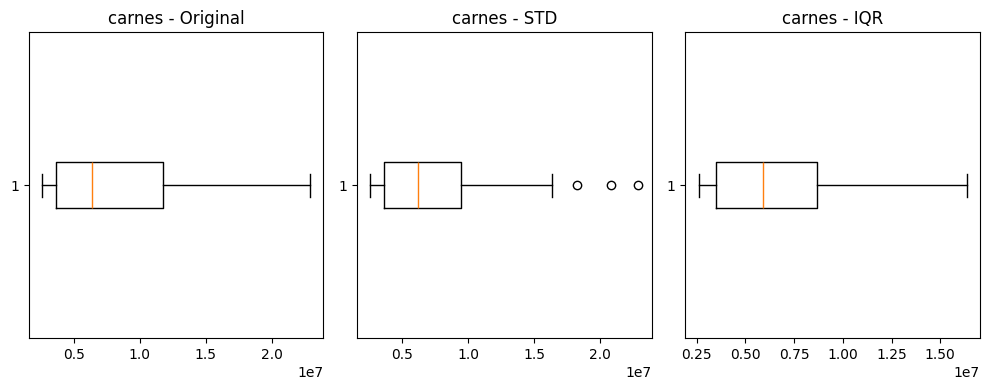

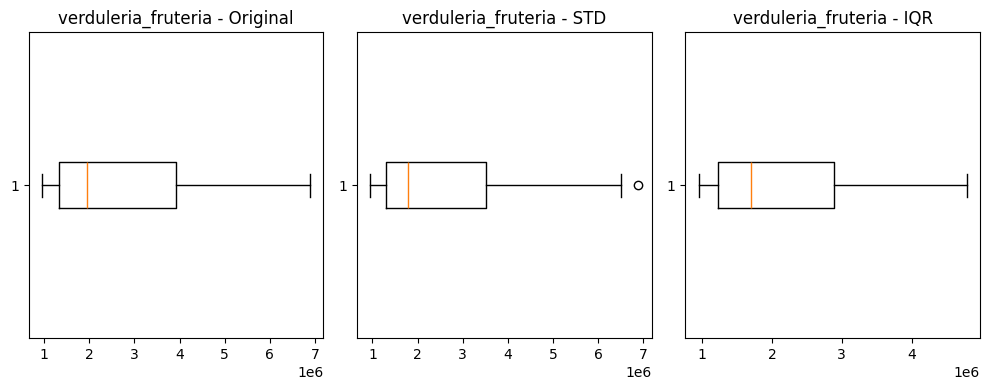

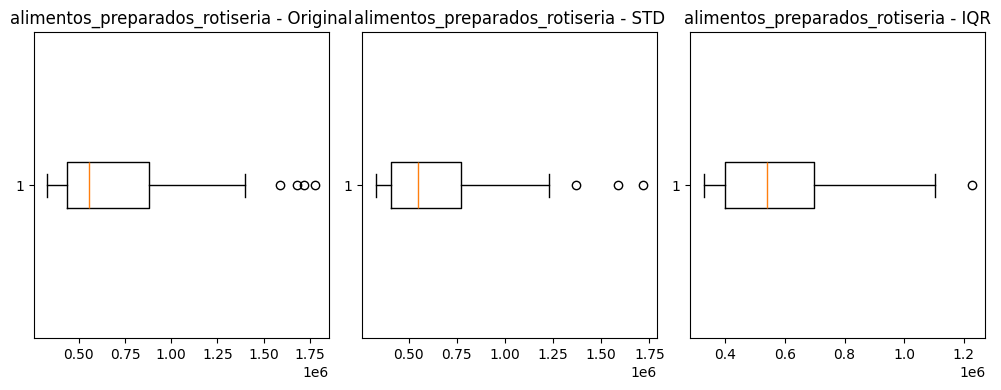

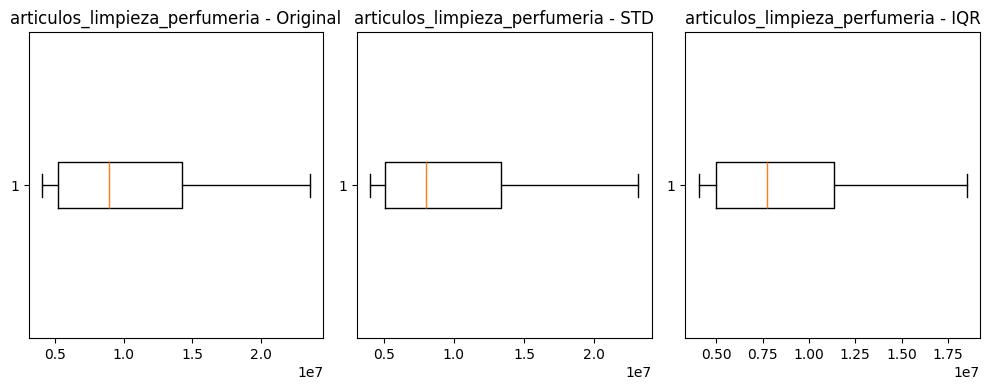

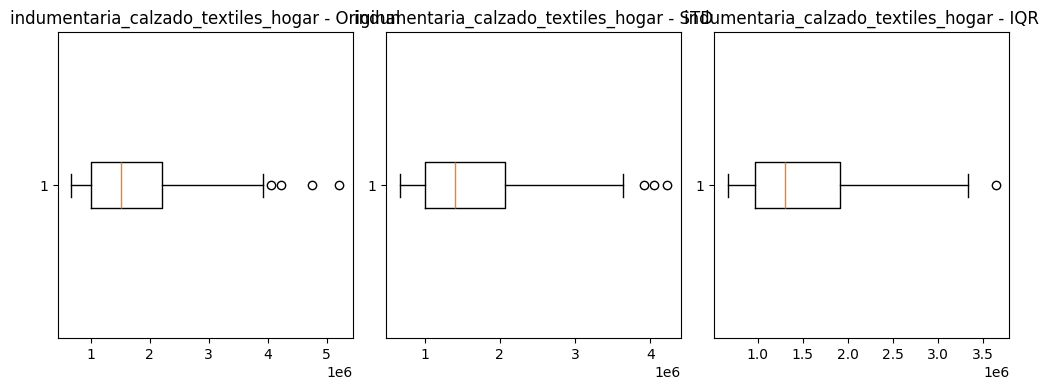

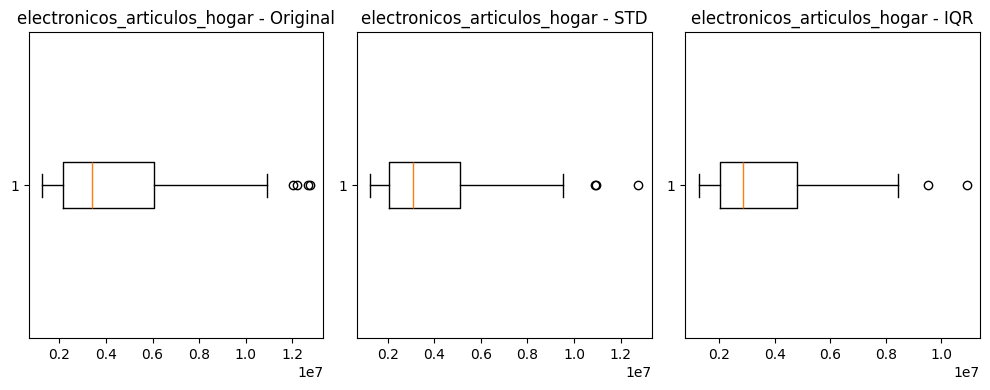

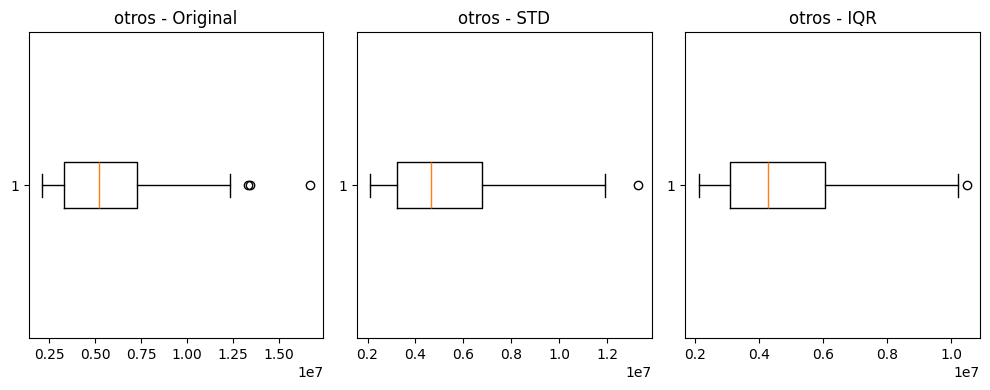

In [9]:
# ===== Boxplots de comprobación por columna =====
# Para cada variable numérica, mostramos 3 diagramas de caja:
#   - Base limpia (solo nulos imputados)
#   - Después de filtrar por STD
#   - Después de filtrar por IQR
for c in num_cols:
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 3, 1)
    plt.boxplot(df_imp[c].dropna(), vert=False)
    plt.title(f"{c} - Original")

    plt.subplot(1, 3, 2)
    plt.boxplot(df_std[c].dropna(), vert=False)
    plt.title(f"{c} - STD")

    plt.subplot(1, 3, 3)
    plt.boxplot(df_iqr[c].dropna(), vert=False)
    plt.title(f"{c} - IQR")

    plt.tight_layout()
    plt.show()